In [161]:
# 기본적인 부분
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc("font", family="NanumGothic")
plt.rcParams["axes.unicode_minus"]=False

# 데이터 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# 학습 알고리즘
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet

from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report
from scipy.special import expit, softmax

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

from sklearn.ensemble import RandomForestClassifier

# 서울시 상권 월간 매출 예측 모델

## 상권 추정매출

In [3]:
seoul_sales = pd.read_csv("../data/서울시 상권분석서비스(추정매출-상권).csv", encoding="cp949")
seoul_sales.shape

(87179, 55)

In [4]:
seoul_sales.head()

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,...,시간대_건수~21_매출_건수,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수
0,20241,U,관광특구,3001491,이태원 관광특구,CS100001,한식음식점,1.185751e+10,254192,6.640829e+09,...,69016,38472,129419,109336,1277,73116,86124,33511,28074,16652
1,20241,U,관광특구,3001491,이태원 관광특구,CS100002,중식음식점,1.911647e+09,46140,1.259317e+09,...,18085,4918,21479,21646,151,14443,15206,5918,4892,2514
2,20241,U,관광특구,3001491,이태원 관광특구,CS100003,일식음식점,7.273213e+08,10811,4.611840e+08,...,3596,2734,4855,4682,52,2911,3636,1345,1222,371
3,20241,U,관광특구,3001491,이태원 관광특구,CS100004,양식음식점,1.673468e+10,414722,8.256458e+09,...,135195,83964,228805,173511,3268,151680,156120,45901,31260,14074
4,20241,U,관광특구,3001491,이태원 관광특구,CS100005,제과점,1.255782e+09,96224,7.704259e+08,...,28562,8063,38105,54368,660,29740,28886,12736,12976,7472


In [5]:
seoul_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87179 entries, 0 to 87178
Data columns (total 55 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   기준_년분기_코드        87179 non-null  int64  
 1   상권_구분_코드         87179 non-null  object 
 2   상권_구분_코드_명       87179 non-null  object 
 3   상권_코드            87179 non-null  int64  
 4   상권_코드_명          87179 non-null  object 
 5   서비스_업종_코드        87179 non-null  object 
 6   서비스_업종_코드_명      87179 non-null  object 
 7   당월_매출_금액         87179 non-null  float64
 8   당월_매출_건수         87179 non-null  int64  
 9   주중_매출_금액         87179 non-null  float64
 10  주말_매출_금액         87179 non-null  float64
 11  월요일_매출_금액        87179 non-null  float64
 12  화요일_매출_금액        87179 non-null  float64
 13  수요일_매출_금액        87179 non-null  float64
 14  목요일_매출_금액        87179 non-null  float64
 15  금요일_매출_금액        87179 non-null  float64
 16  토요일_매출_금액        87179 non-null  float64
 17  일요일_매출_금액   

In [6]:
seoul_sales_copy=seoul_sales.copy()

In [7]:
seoul_sales_copy["출근_매출_금액"] = (seoul_sales_copy["시간대_00~06_매출_금액"] + seoul_sales_copy["시간대_06~11_매출_금액"])
seoul_sales_copy["점심_매출_금액"] = (seoul_sales_copy["시간대_11~14_매출_금액"] + seoul_sales_copy["시간대_14~17_매출_금액"])
seoul_sales_copy["퇴근_매출_금액"] = (seoul_sales_copy["시간대_17~21_매출_금액"] + seoul_sales_copy["시간대_21~24_매출_금액"])

columns_to_drop = [
    "서비스_업종_코드", "서비스_업종_코드_명", "상권_구분_코드", "상권_코드",
    "월요일_매출_금액", "화요일_매출_금액", "수요일_매출_금액", "목요일_매출_금액", "금요일_매출_금액",
    "토요일_매출_금액", "일요일_매출_금액",
    "시간대_00~06_매출_금액", "시간대_06~11_매출_금액",
    "시간대_11~14_매출_금액", "시간대_14~17_매출_금액",
    "시간대_17~21_매출_금액", "시간대_21~24_매출_금액",
    "연령대_10_매출_금액", "연령대_20_매출_금액", "연령대_30_매출_금액", 
    "연령대_40_매출_금액", "연령대_50_매출_금액", "연령대_60_이상_매출_금액", 
    "당월_매출_건수", "주중_매출_건수", "주말_매출_건수",
    "월요일_매출_건수", "화요일_매출_건수", "수요일_매출_건수", "목요일_매출_건수", "금요일_매출_건수",
    "토요일_매출_건수", "일요일_매출_건수",
    "시간대_건수~06_매출_건수", "시간대_건수~11_매출_건수",
    "시간대_건수~14_매출_건수", "시간대_건수~17_매출_건수",
    "시간대_건수~21_매출_건수", "시간대_건수~24_매출_건수",
    "남성_매출_건수", "여성_매출_건수",
    "연령대_10_매출_건수", "연령대_20_매출_건수", "연령대_30_매출_건수",
    "연령대_40_매출_건수", "연령대_50_매출_건수", "연령대_60_이상_매출_건수"
]

seoul_sales_copy = seoul_sales_copy.drop(columns=columns_to_drop)
seoul_sales_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87179 entries, 0 to 87178
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   기준_년분기_코드   87179 non-null  int64  
 1   상권_구분_코드_명  87179 non-null  object 
 2   상권_코드_명     87179 non-null  object 
 3   당월_매출_금액    87179 non-null  float64
 4   주중_매출_금액    87179 non-null  float64
 5   주말_매출_금액    87179 non-null  float64
 6   남성_매출_금액    87179 non-null  float64
 7   여성_매출_금액    87179 non-null  float64
 8   출근_매출_금액    87179 non-null  float64
 9   점심_매출_금액    87179 non-null  float64
 10  퇴근_매출_금액    87179 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 7.3+ MB


In [8]:
columns_to_sum = seoul_sales_copy.columns[3:20]  # 매출 컬럼

agg_func = {}
# 기준_년분기_코드, 상권_구분_코드_명, 상권_코드_명
for col in seoul_sales_copy.columns[:3]:
    agg_func[col] = "first"
# 나머지
for col in columns_to_sum:
    agg_func[col] = "sum"

seoul_sales_copy_grouped = seoul_sales_copy.groupby(["상권_코드_명", "기준_년분기_코드"]).agg(agg_func)
seoul_sales_copy_grouped.head()

기준_년분기_코드 상권_구분_코드_명       상권_코드_명      당월_매출_금액  \
상권_코드_명      기준_년분기_코드                                                     
4.19민주묘지역 2번 20241          20241       골목상권  4.19민주묘지역 2번  2.612731e+09   
             20242          20242       골목상권  4.19민주묘지역 2번  3.533239e+09   
             20243          20243       골목상권  4.19민주묘지역 2번  3.197639e+09   
             20244          20244       골목상권  4.19민주묘지역 2번  2.733308e+09   
63빌딩         20241          20241       발달상권          63빌딩  2.583266e+10   

                            주중_매출_금액      주말_매출_금액      남성_매출_금액  \
상권_코드_명      기준_년분기_코드                                             
4.19민주묘지역 2번 20241      1.652561e+09  9.601700e+08  1.474064e+09   
             20242      2.228981e+09  1.304257e+09  1.954385e+09   
             20243      1.952483e+09  1.245156e+09  1.741504e+09   
             20244      1.733142e+09  1.000167e+09  1.440694e+09   
63빌딩         20241      2.465147e+10  1.181194e+09  1.816752e+10   

                            여성_매출_금액      출근_매출_금액      점심_매출_금액      퇴근_매출_금액  
상권_코드_명      기준_년분기_코드                                                          
4.19민주묘지역 2번 20241      1.054124e+09  2.384139e+08  1.093005e+09  1.281312e+09  
             20242      1.448425e+09  2.656644e+08  1.618132e+09  1.649442e+09  
             20243      1.274372e+09  2.470045e+08  1.535506e+09  1.415128e+09  
             20244      1.076676e+09  2.547436e+08  1.310020e+09  1.168544e+09  
63빌딩         20241      5.278512e+09  8.995803e+09  1.511013e+10  1.726733e+09

In [9]:
seoul_sales_copy_grouped = seoul_sales_copy_grouped.reset_index(drop=True)

In [10]:
seoul_sales_copy_grouped_sort = seoul_sales_copy_grouped.sort_values(by="기준_년분기_코드", ascending=True)

In [11]:
seoul_sales_copy_grouped_sort.head()

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,당월_매출_금액,주중_매출_금액,주말_매출_금액,남성_매출_금액,여성_매출_금액,출근_매출_금액,점심_매출_금액,퇴근_매출_금액
6263,20241,전통시장,후암시장,5.647312e+09,4.243084e+09,1.404228e+09,2.417029e+09,2.701924e+09,7.251804e+08,2.526578e+09,2.395553e+09
6259,20241,골목상권,후암동주민센터,7.370590e+09,5.602067e+09,1.768522e+09,2.989562e+09,3.105683e+09,6.148078e+08,3.305475e+09,3.450307e+09
16,20241,골목상권,G타워,2.552906e+09,1.878170e+09,6.747357e+08,1.780755e+09,6.950993e+08,5.642522e+08,5.751115e+08,1.413542e+09
12,20241,골목상권,GS강동자이아파트,2.129201e+09,1.524863e+09,6.043383e+08,1.208088e+09,8.162529e+08,2.013702e+08,8.830627e+08,1.044768e+09
8,20241,발달상권,DMC(디지털미디어시티),4.384641e+10,3.833809e+10,5.508317e+09,1.770406e+10,1.599563e+10,5.393219e+09,2.618755e+10,1.226563e+10


In [12]:
seoul_sales_copy_grouped_sort = seoul_sales_copy_grouped_sort.reset_index(drop=True)

In [13]:
seoul_sales_copy_grouped_sort.head()

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,당월_매출_금액,주중_매출_금액,주말_매출_금액,남성_매출_금액,여성_매출_금액,출근_매출_금액,점심_매출_금액,퇴근_매출_금액
0,20241,전통시장,후암시장,5.647312e+09,4.243084e+09,1.404228e+09,2.417029e+09,2.701924e+09,7.251804e+08,2.526578e+09,2.395553e+09
1,20241,골목상권,후암동주민센터,7.370590e+09,5.602067e+09,1.768522e+09,2.989562e+09,3.105683e+09,6.148078e+08,3.305475e+09,3.450307e+09
2,20241,골목상권,G타워,2.552906e+09,1.878170e+09,6.747357e+08,1.780755e+09,6.950993e+08,5.642522e+08,5.751115e+08,1.413542e+09
3,20241,골목상권,GS강동자이아파트,2.129201e+09,1.524863e+09,6.043383e+08,1.208088e+09,8.162529e+08,2.013702e+08,8.830627e+08,1.044768e+09
4,20241,발달상권,DMC(디지털미디어시티),4.384641e+10,3.833809e+10,5.508317e+09,1.770406e+10,1.599563e+10,5.393219e+09,2.618755e+10,1.226563e+10


In [14]:
seoul_sales_copy_grouped_sort["상권_코드_명"].unique()

array(['후암시장', '후암동주민센터', 'G타워', ..., '문래역 3번', '배꽃어린이공원',
       '본마을노인복지센터(서초구립내곡도서관)'], shape=(1581,), dtype=object)

## 유동인구

In [15]:
seoul_people_street=pd.read_csv("../data/서울시 상권분석서비스(길단위인구-상권).csv", encoding="cp949")
seoul_people_street.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6595 entries, 0 to 6594
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   기준_년분기_코드         6595 non-null   int64 
 1   상권_구분_코드          6595 non-null   object
 2   상권_구분_코드_명        6595 non-null   object
 3   상권_코드             6595 non-null   int64 
 4   상권_코드_명           6595 non-null   object
 5   총_유동인구_수          6595 non-null   int64 
 6   남성_유동인구_수         6595 non-null   int64 
 7   여성_유동인구_수         6595 non-null   int64 
 8   연령대_10_유동인구_수     6595 non-null   int64 
 9   연령대_20_유동인구_수     6595 non-null   int64 
 10  연령대_30_유동인구_수     6595 non-null   int64 
 11  연령대_40_유동인구_수     6595 non-null   int64 
 12  연령대_50_유동인구_수     6595 non-null   int64 
 13  연령대_60_이상_유동인구_수  6595 non-null   int64 
 14  시간대_00_06_유동인구_수  6595 non-null   int64 
 15  시간대_06_11_유동인구_수  6595 non-null   int64 
 16  시간대_11_14_유동인구_수  6595 non-null   int64 
 17  시간대_14_17_유동인구

In [16]:
seoul_people_street_copy=seoul_people_street.copy()

In [17]:
seoul_people_street_copy["출근_유동인구_수"] = (seoul_people_street_copy["시간대_00_06_유동인구_수"] + seoul_people_street_copy["시간대_06_11_유동인구_수"])
seoul_people_street_copy["점심_유동인구_수"] = (seoul_people_street_copy["시간대_11_14_유동인구_수"] + seoul_people_street_copy["시간대_14_17_유동인구_수"])
seoul_people_street_copy["퇴근_유동인구_수"] = (seoul_people_street_copy["시간대_17_21_유동인구_수"] + seoul_people_street_copy["시간대_21_24_유동인구_수"])

seoul_people_street_copy["주중_유동인구_수"] = (seoul_people_street_copy["월요일_유동인구_수"] +
                                                 seoul_people_street_copy["화요일_유동인구_수"] +
                                                 seoul_people_street_copy["수요일_유동인구_수"] +
                                                 seoul_people_street_copy["목요일_유동인구_수"] +
                                                 seoul_people_street_copy["금요일_유동인구_수"])
seoul_people_street_copy["주말_유동인구_수"] = (seoul_people_street_copy["토요일_유동인구_수"] +
                                                 seoul_people_street_copy["일요일_유동인구_수"])

columns_to_drop = [
    "상권_구분_코드", "상권_코드",
    "연령대_10_유동인구_수", "연령대_20_유동인구_수", "연령대_30_유동인구_수", 
    "연령대_40_유동인구_수", "연령대_50_유동인구_수", "연령대_60_이상_유동인구_수", 
    "시간대_00_06_유동인구_수", "시간대_06_11_유동인구_수",
    "시간대_11_14_유동인구_수", "시간대_14_17_유동인구_수",
    "시간대_17_21_유동인구_수", "시간대_21_24_유동인구_수",
    "월요일_유동인구_수", "화요일_유동인구_수", "수요일_유동인구_수", "목요일_유동인구_수", "금요일_유동인구_수",
    "토요일_유동인구_수", "일요일_유동인구_수"
]

seoul_people_street_copy = seoul_people_street_copy.drop(columns=columns_to_drop)
seoul_people_street_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6595 entries, 0 to 6594
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   기준_년분기_코드   6595 non-null   int64 
 1   상권_구분_코드_명  6595 non-null   object
 2   상권_코드_명     6595 non-null   object
 3   총_유동인구_수    6595 non-null   int64 
 4   남성_유동인구_수   6595 non-null   int64 
 5   여성_유동인구_수   6595 non-null   int64 
 6   출근_유동인구_수   6595 non-null   int64 
 7   점심_유동인구_수   6595 non-null   int64 
 8   퇴근_유동인구_수   6595 non-null   int64 
 9   주중_유동인구_수   6595 non-null   int64 
 10  주말_유동인구_수   6595 non-null   int64 
dtypes: int64(9), object(2)
memory usage: 566.9+ KB


In [18]:
seoul_people_street_copy.head()

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,출근_유동인구_수,점심_유동인구_수,퇴근_유동인구_수,주중_유동인구_수,주말_유동인구_수
0,20241,관광특구,이태원 관광특구,2155176,1100997,1054179,825910,616767,712501,1448259,706917
1,20241,관광특구,명동 남대문 북창동 다동 무교동 관광특구,6889856,3343470,3546388,1797535,3421049,1671272,5610790,1279068
2,20241,관광특구,동대문패션타운 관광특구,3384560,1595828,1788732,1319830,1041981,1022749,2621333,763228
3,20241,관광특구,종로?청계 관광특구,8440796,4496772,3944023,2502267,3586470,2352059,6677540,1763257
4,20241,관광특구,잠실 관광특구,4110178,1976808,2133370,1481825,1270950,1357403,2909899,1200277


In [19]:
seoul_people_street_copy = seoul_people_street_copy.reset_index(drop=True)

In [20]:
seoul_sales_people_street = pd.merge(seoul_sales_copy_grouped_sort, seoul_people_street_copy, on=["기준_년분기_코드", "상권_구분_코드_명", "상권_코드_명"], how="inner")
seoul_sales_people_street.head()

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,당월_매출_금액,주중_매출_금액,주말_매출_금액,남성_매출_금액,여성_매출_금액,출근_매출_금액,점심_매출_금액,퇴근_매출_금액,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,출근_유동인구_수,점심_유동인구_수,퇴근_유동인구_수,주중_유동인구_수,주말_유동인구_수
0,20241,전통시장,후암시장,5.647312e+09,4.243084e+09,1.404228e+09,2.417029e+09,2.701924e+09,7.251804e+08,2.526578e+09,2.395553e+09,153058,71506,81552,53787,43100,56171,107585,45472
1,20241,골목상권,후암동주민센터,7.370590e+09,5.602067e+09,1.768522e+09,2.989562e+09,3.105683e+09,6.148078e+08,3.305475e+09,3.450307e+09,2164454,1027045,1137408,1158771,439663,566019,1538245,626208
2,20241,골목상권,G타워,2.552906e+09,1.878170e+09,6.747357e+08,1.780755e+09,6.950993e+08,5.642522e+08,5.751115e+08,1.413542e+09,343585,197255,146329,166684,89110,87789,258525,85056
3,20241,골목상권,GS강동자이아파트,2.129201e+09,1.524863e+09,6.043383e+08,1.208088e+09,8.162529e+08,2.013702e+08,8.830627e+08,1.044768e+09,829493,390022,439469,387147,195380,246964,569935,259557
4,20241,발달상권,DMC(디지털미디어시티),4.384641e+10,3.833809e+10,5.508317e+09,1.770406e+10,1.599563e+10,5.393219e+09,2.618755e+10,1.226563e+10,504301,249612,254689,157314,214064,132923,418206,86096


In [21]:
seoul_sales_people_street_sorted = seoul_sales_people_street.sort_values(by="기준_년분기_코드", ascending=True)

In [22]:
seoul_people_street_copy = seoul_people_street_copy.reset_index(drop=True)
seoul_people_street_copy.head()

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,출근_유동인구_수,점심_유동인구_수,퇴근_유동인구_수,주중_유동인구_수,주말_유동인구_수
0,20241,관광특구,이태원 관광특구,2155176,1100997,1054179,825910,616767,712501,1448259,706917
1,20241,관광특구,명동 남대문 북창동 다동 무교동 관광특구,6889856,3343470,3546388,1797535,3421049,1671272,5610790,1279068
2,20241,관광특구,동대문패션타운 관광특구,3384560,1595828,1788732,1319830,1041981,1022749,2621333,763228
3,20241,관광특구,종로?청계 관광특구,8440796,4496772,3944023,2502267,3586470,2352059,6677540,1763257
4,20241,관광특구,잠실 관광특구,4110178,1976808,2133370,1481825,1270950,1357403,2909899,1200277


In [23]:
seoul_sales_people_street.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6274 entries, 0 to 6273
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   기준_년분기_코드   6274 non-null   int64  
 1   상권_구분_코드_명  6274 non-null   object 
 2   상권_코드_명     6274 non-null   object 
 3   당월_매출_금액    6274 non-null   float64
 4   주중_매출_금액    6274 non-null   float64
 5   주말_매출_금액    6274 non-null   float64
 6   남성_매출_금액    6274 non-null   float64
 7   여성_매출_금액    6274 non-null   float64
 8   출근_매출_금액    6274 non-null   float64
 9   점심_매출_금액    6274 non-null   float64
 10  퇴근_매출_금액    6274 non-null   float64
 11  총_유동인구_수    6274 non-null   int64  
 12  남성_유동인구_수   6274 non-null   int64  
 13  여성_유동인구_수   6274 non-null   int64  
 14  출근_유동인구_수   6274 non-null   int64  
 15  점심_유동인구_수   6274 non-null   int64  
 16  퇴근_유동인구_수   6274 non-null   int64  
 17  주중_유동인구_수   6274 non-null   int64  
 18  주말_유동인구_수   6274 non-null   int64  
dtypes: float64(8), int64(9), ob

## 직장인구

In [24]:
seoul_people_working=pd.read_csv("../data/서울시 상권분석서비스(직장인구-상권).csv", encoding="cp949")
seoul_people_working.shape

(6549, 26)

In [25]:
seoul_people_working.head()

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수,연령대_10_직장_인구_수,연령대_20_직장_인구_수,...,남성연령대_30_직장_인구_수,남성연령대_40_직장_인구_수,남성연령대_50_직장_인구_수,남성연령대_60_이상_직장_인구_수,여성연령대_10_직장_인구_수,여성연령대_20_직장_인구_수,여성연령대_30_직장_인구_수,여성연령대_40_직장_인구_수,여성연령대_50_직장_인구_수,여성연령대_60_이상_직장_인구_수
0,20241,U,관광특구,3001491,이태원 관광특구,28395,15935,12460,8,6830,...,4986,4313,3583,842,0,4627,4869,2052,722,190
1,20241,U,관광특구,3001492,명동 남대문 북창동 다동 무교동 관광특구,214604,123445,91159,396,43270,...,38123,36717,25448,6374,309,26574,33802,18817,8660,2997
2,20241,U,관광특구,3001493,동대문패션타운 관광특구,33474,16833,16641,273,9661,...,4972,3883,2050,1183,164,5025,3641,2930,3328,1553
3,20241,U,관광특구,3001494,종로?청계 관광특구,47296,26388,20908,670,9566,...,7326,7672,5302,1732,428,5452,6816,5204,2256,752
4,20241,U,관광특구,3001495,잠실 관광특구,111557,65817,45740,195,18343,...,18331,18070,13050,7197,115,9254,10943,10338,11338,3752


In [26]:
seoul_people_working_copy=seoul_people_working.copy()

In [27]:
seoul_people_working_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6549 entries, 0 to 6548
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   기준_년분기_코드            6549 non-null   int64 
 1   상권_구분_코드             6549 non-null   object
 2   상권_구분_코드_명           6549 non-null   object
 3   상권_코드                6549 non-null   int64 
 4   상권_코드_명              6549 non-null   object
 5   총_직장_인구_수            6549 non-null   int64 
 6   남성_직장_인구_수           6549 non-null   int64 
 7   여성_직장_인구_수           6549 non-null   int64 
 8   연령대_10_직장_인구_수       6549 non-null   int64 
 9   연령대_20_직장_인구_수       6549 non-null   int64 
 10  연령대_30_직장_인구_수       6549 non-null   int64 
 11  연령대_40_직장_인구_수       6549 non-null   int64 
 12  연령대_50_직장_인구_수       6549 non-null   int64 
 13  연령대_60_이상_직장_인구_수    6549 non-null   int64 
 14  남성연령대_10_직장_인구_수     6549 non-null   int64 
 15  남성연령대_20_직장_인구_수     6549 non-null   int64 
 16  남성연령대_

In [28]:
columns_to_drop = [
    "상권_구분_코드", "상권_코드",
    "연령대_10_직장_인구_수", "연령대_20_직장_인구_수", "연령대_30_직장_인구_수", 
    "연령대_40_직장_인구_수", "연령대_50_직장_인구_수", "연령대_60_이상_직장_인구_수", 
    "남성연령대_10_직장_인구_수", "남성연령대_20_직장_인구_수", "남성연령대_30_직장_인구_수",
    "남성연령대_40_직장_인구_수", "남성연령대_50_직장_인구_수", "남성연령대_60_이상_직장_인구_수",
    "여성연령대_10_직장_인구_수", "여성연령대_20_직장_인구_수", "여성연령대_30_직장_인구_수",
    "여성연령대_40_직장_인구_수", "여성연령대_50_직장_인구_수", "여성연령대_60_이상_직장_인구_수"
]

seoul_people_working_copy = seoul_people_working_copy.drop(columns=columns_to_drop)
seoul_people_working_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6549 entries, 0 to 6548
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   기준_년분기_코드   6549 non-null   int64 
 1   상권_구분_코드_명  6549 non-null   object
 2   상권_코드_명     6549 non-null   object
 3   총_직장_인구_수   6549 non-null   int64 
 4   남성_직장_인구_수  6549 non-null   int64 
 5   여성_직장_인구_수  6549 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 307.1+ KB


In [29]:
seoul_people_working_copy.head()

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수
0,20241,관광특구,이태원 관광특구,28395,15935,12460
1,20241,관광특구,명동 남대문 북창동 다동 무교동 관광특구,214604,123445,91159
2,20241,관광특구,동대문패션타운 관광특구,33474,16833,16641
3,20241,관광특구,종로?청계 관광특구,47296,26388,20908
4,20241,관광특구,잠실 관광특구,111557,65817,45740


In [30]:
seoul_sales_people_street_working = pd.merge(seoul_sales_people_street, seoul_people_working_copy, on=["기준_년분기_코드", "상권_구분_코드_명", "상권_코드_명"], how="inner")
seoul_sales_people_street_working.head()

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,당월_매출_금액,주중_매출_금액,주말_매출_금액,남성_매출_금액,여성_매출_금액,출근_매출_금액,점심_매출_금액,...,남성_유동인구_수,여성_유동인구_수,출근_유동인구_수,점심_유동인구_수,퇴근_유동인구_수,주중_유동인구_수,주말_유동인구_수,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수
0,20241,전통시장,후암시장,5.647312e+09,4.243084e+09,1.404228e+09,2.417029e+09,2.701924e+09,7.251804e+08,2.526578e+09,...,71506,81552,53787,43100,56171,107585,45472,188,112,76
1,20241,골목상권,후암동주민센터,7.370590e+09,5.602067e+09,1.768522e+09,2.989562e+09,3.105683e+09,6.148078e+08,3.305475e+09,...,1027045,1137408,1158771,439663,566019,1538245,626208,1044,619,425
2,20241,골목상권,G타워,2.552906e+09,1.878170e+09,6.747357e+08,1.780755e+09,6.950993e+08,5.642522e+08,5.751115e+08,...,197255,146329,166684,89110,87789,258525,85056,2711,1778,933
3,20241,골목상권,GS강동자이아파트,2.129201e+09,1.524863e+09,6.043383e+08,1.208088e+09,8.162529e+08,2.013702e+08,8.830627e+08,...,390022,439469,387147,195380,246964,569935,259557,282,144,138
4,20241,발달상권,DMC(디지털미디어시티),4.384641e+10,3.833809e+10,5.508317e+09,1.770406e+10,1.599563e+10,5.393219e+09,2.618755e+10,...,249612,254689,157314,214064,132923,418206,86096,12628,7785,4843


In [31]:
seoul_sales_people_street_working.rename(columns={"당월_매출_금액": "매출_금액"}, inplace=True)

def seasons(row):
    if row == 20241:
        return "봄"
    elif row == 20242:
        return "여름"
    elif row == 20243:
        return "가을"
    else:
        return "겨울"

seoul_sales_people_street_working["계절"] = seoul_sales_people_street_working["기준_년분기_코드"
                                                                            ].apply(seasons)
seoul_sales_people_street_working.insert(seoul_sales_people_street_working.columns.get_loc("기준_년분기_코드") + 1, "계절", seoul_sales_people_street_working.pop("계절"))

In [32]:
seoul_sales_people_street_working = seoul_sales_people_street_working.sort_values(by="기준_년분기_코드", ascending=True)

In [33]:
seoul_sales_people_street_working = seoul_sales_people_street_working.reset_index(drop=True)
seoul_sales_people_street_working.head()

,기준_년분기_코드,계절,상권_구분_코드_명,상권_코드_명,매출_금액,주중_매출_금액,주말_매출_금액,남성_매출_금액,여성_매출_금액,출근_매출_금액,...,남성_유동인구_수,여성_유동인구_수,출근_유동인구_수,점심_유동인구_수,퇴근_유동인구_수,주중_유동인구_수,주말_유동인구_수,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수
0,20241,봄,골목상권,도신초등학교,1.335972e+10,1.125952e+10,2.100204e+09,6.519916e+09,3.053532e+09,3.504188e+09,...,403167,422501,414335,177866,233464,580968,244698,393,256,137
1,20241,봄,전통시장,도화동 상점가,3.024954e+10,2.381858e+10,6.430966e+09,1.536653e+10,9.215702e+09,2.946713e+09,...,736117,844811,531416,512010,537500,1153921,427006,2419,1469,950
2,20241,봄,골목상권,독립문역 1번,4.995097e+09,4.569642e+09,4.254550e+08,2.333809e+09,2.494054e+09,1.172737e+09,...,226914,290934,219530,144840,153479,374072,143780,403,109,294
3,20241,봄,발달상권,63빌딩,2.583266e+10,2.465147e+10,1.181194e+09,1.816752e+10,5.278512e+09,8.995803e+09,...,31901,30233,24777,21794,15563,48180,13956,8016,5688,2328
4,20241,봄,발달상권,DMC(디지털미디어시티),4.384641e+10,3.833809e+10,5.508317e+09,1.770406e+10,1.599563e+10,5.393219e+09,...,249612,254689,157314,214064,132923,418206,86096,12628,7785,4843


In [34]:
seoul_sales_people_street_working.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6241 entries, 0 to 6240
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   기준_년분기_코드   6241 non-null   int64  
 1   계절          6241 non-null   object 
 2   상권_구분_코드_명  6241 non-null   object 
 3   상권_코드_명     6241 non-null   object 
 4   매출_금액       6241 non-null   float64
 5   주중_매출_금액    6241 non-null   float64
 6   주말_매출_금액    6241 non-null   float64
 7   남성_매출_금액    6241 non-null   float64
 8   여성_매출_금액    6241 non-null   float64
 9   출근_매출_금액    6241 non-null   float64
 10  점심_매출_금액    6241 non-null   float64
 11  퇴근_매출_금액    6241 non-null   float64
 12  총_유동인구_수    6241 non-null   int64  
 13  남성_유동인구_수   6241 non-null   int64  
 14  여성_유동인구_수   6241 non-null   int64  
 15  출근_유동인구_수   6241 non-null   int64  
 16  점심_유동인구_수   6241 non-null   int64  
 17  퇴근_유동인구_수   6241 non-null   int64  
 18  주중_유동인구_수   6241 non-null   int64  
 19  주말_유동인구_수   6241 non-null  

In [35]:
seoul_sales_people_street_working.to_csv("../data/seoul_sales.csv", index=False)

## 데이터 전처리
> 상관관계 확인  
> 각 변수 시각화  

In [39]:
seoul_data=pd.read_csv("../data/seoul_sales.csv")
seoul_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6241 entries, 0 to 6240
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   기준_년분기_코드   6241 non-null   int64  
 1   계절          6241 non-null   object 
 2   상권_구분_코드_명  6241 non-null   object 
 3   상권_코드_명     6241 non-null   object 
 4   매출_금액       6241 non-null   float64
 5   주중_매출_금액    6241 non-null   float64
 6   주말_매출_금액    6241 non-null   float64
 7   남성_매출_금액    6241 non-null   float64
 8   여성_매출_금액    6241 non-null   float64
 9   출근_매출_금액    6241 non-null   float64
 10  점심_매출_금액    6241 non-null   float64
 11  퇴근_매출_금액    6241 non-null   float64
 12  총_유동인구_수    6241 non-null   int64  
 13  남성_유동인구_수   6241 non-null   int64  
 14  여성_유동인구_수   6241 non-null   int64  
 15  출근_유동인구_수   6241 non-null   int64  
 16  점심_유동인구_수   6241 non-null   int64  
 17  퇴근_유동인구_수   6241 non-null   int64  
 18  주중_유동인구_수   6241 non-null   int64  
 19  주말_유동인구_수   6241 non-null  

### 상관관계 확인

In [155]:
numeric_columns = seoul_data.select_dtypes(include=["float64", "int64"])
correlation_matrix = numeric_columns.corr()
correlation_matrix

,기준_년분기_코드,매출_금액,주중_매출_금액,주말_매출_금액,남성_매출_금액,여성_매출_금액,출근_매출_금액,점심_매출_금액,퇴근_매출_금액,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,출근_유동인구_수,점심_유동인구_수,퇴근_유동인구_수,주중_유동인구_수,주말_유동인구_수,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수
기준_년분기_코드,1.000000,0.003325,0.004074,0.001362,0.000131,0.001044,0.004565,0.003172,0.002252,-0.008522,-0.009857,-0.007224,-0.010115,-0.006654,-0.007244,-0.008850,-0.007430,0.005128,0.005001,0.005234
매출_금액,0.003325,1.000000,0.990482,0.948782,0.988600,0.961456,0.827559,0.975844,0.959070,0.336054,0.354423,0.316674,0.225718,0.451925,0.338316,0.355403,0.275608,0.540652,0.527550,0.551534
주중_매출_금액,0.004074,0.990482,1.000000,0.896265,0.969353,0.949838,0.824473,0.976459,0.931014,0.360681,0.380880,0.339432,0.241120,0.490156,0.359576,0.383435,0.290454,0.571652,0.557708,0.583306
주말_매출_금액,0.001362,0.948782,0.896265,1.000000,0.960546,0.917875,0.774176,0.903132,0.953395,0.254973,0.267802,0.241299,0.173871,0.331153,0.264799,0.265092,0.221394,0.429994,0.419781,0.438311
남성_매출_금액,0.000131,0.988600,0.969353,0.960546,1.000000,0.926963,0.838232,0.955472,0.951527,0.315268,0.334546,0.295187,0.217361,0.413239,0.320297,0.331570,0.263541,0.462291,0.451507,0.470914
여성_매출_금액,0.001044,0.961456,0.949838,0.917875,0.926963,1.000000,0.747083,0.945339,0.938751,0.366111,0.380071,0.350618,0.244497,0.489828,0.373078,0.385208,0.305596,0.604491,0.588491,0.618858
출근_매출_금액,0.004565,0.827559,0.824473,0.774176,0.838232,0.747083,1.000000,0.726772,0.742239,0.223362,0.236924,0.209224,0.150627,0.298838,0.225566,0.235965,0.183880,0.283782,0.274771,0.292967
점심_매출_금액,0.003172,0.975844,0.976459,0.903132,0.955472,0.945339,0.726772,1.000000,0.905058,0.309341,0.328559,0.289356,0.200578,0.432759,0.304703,0.330891,0.243630,0.556452,0.543609,0.566605
퇴근_매출_금액,0.002252,0.959070,0.931014,0.953395,0.951527,0.938751,0.742239,0.905058,1.000000,0.384429,0.400892,0.366485,0.269593,0.490555,0.397565,0.400617,0.331292,0.566583,0.553044,0.577675
총_유동인구_수,-0.008522,0.336054,0.360681,0.254973,0.315268,0.366111,0.223362,0.309341,0.384429,1.000000,0.996144,0.996675,0.969704,0.943244,0.991617,0.997518,0.981859,0.315980,0.294738,0.344457


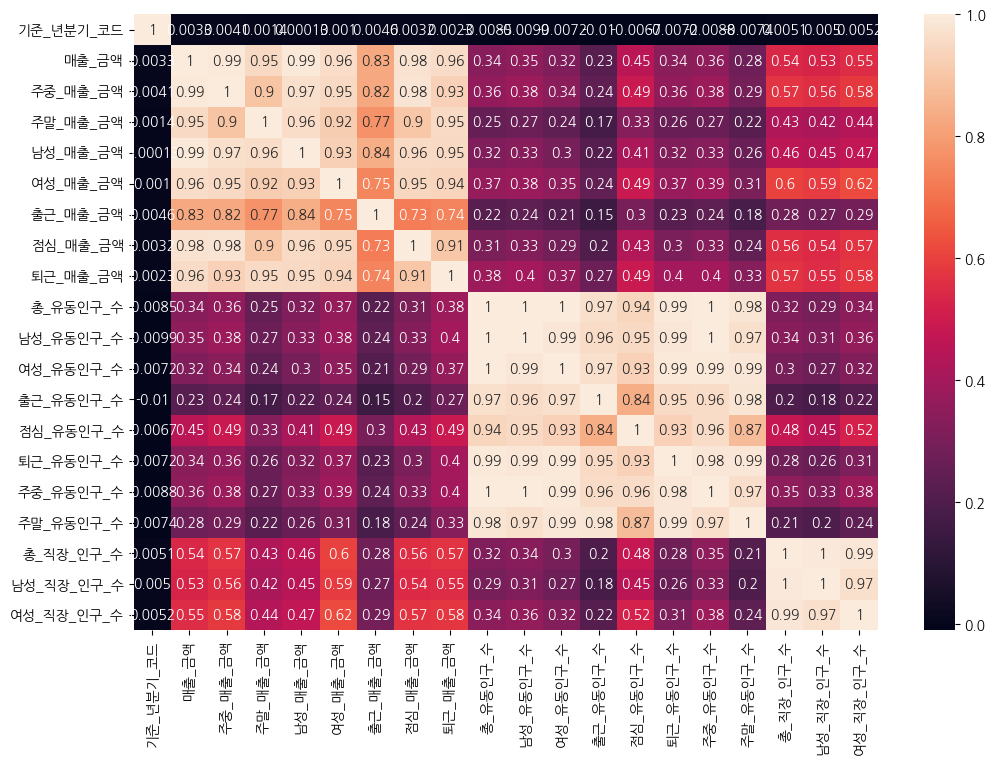

In [156]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

매출금액을 기준으로 상관성을 보면 다음과 같다.  

In [76]:
correlation_with_sales = numeric_columns.corr()["매출_금액"].sort_values(ascending=False)
correlation_with_sales

매출_금액         1.000000
주중_매출_금액      0.990482
남성_매출_금액      0.988600
점심_매출_금액      0.975844
여성_매출_금액      0.961456
퇴근_매출_금액      0.959070
주말_매출_금액      0.948782
출근_매출_금액      0.827559
여성_직장_인구_수    0.551534
총_직장_인구_수     0.540652
남성_직장_인구_수    0.527550
점심_유동인구_수     0.451925
주중_유동인구_수     0.355403
남성_유동인구_수     0.354423
퇴근_유동인구_수     0.338316
총_유동인구_수      0.336054
여성_유동인구_수     0.316674
주말_유동인구_수     0.275608
출근_유동인구_수     0.225718
기준_년분기_코드     0.003325
Name: 매출_금액, dtype: float64

### 시각화

#### 금액관련 변수와 총 매출 금액

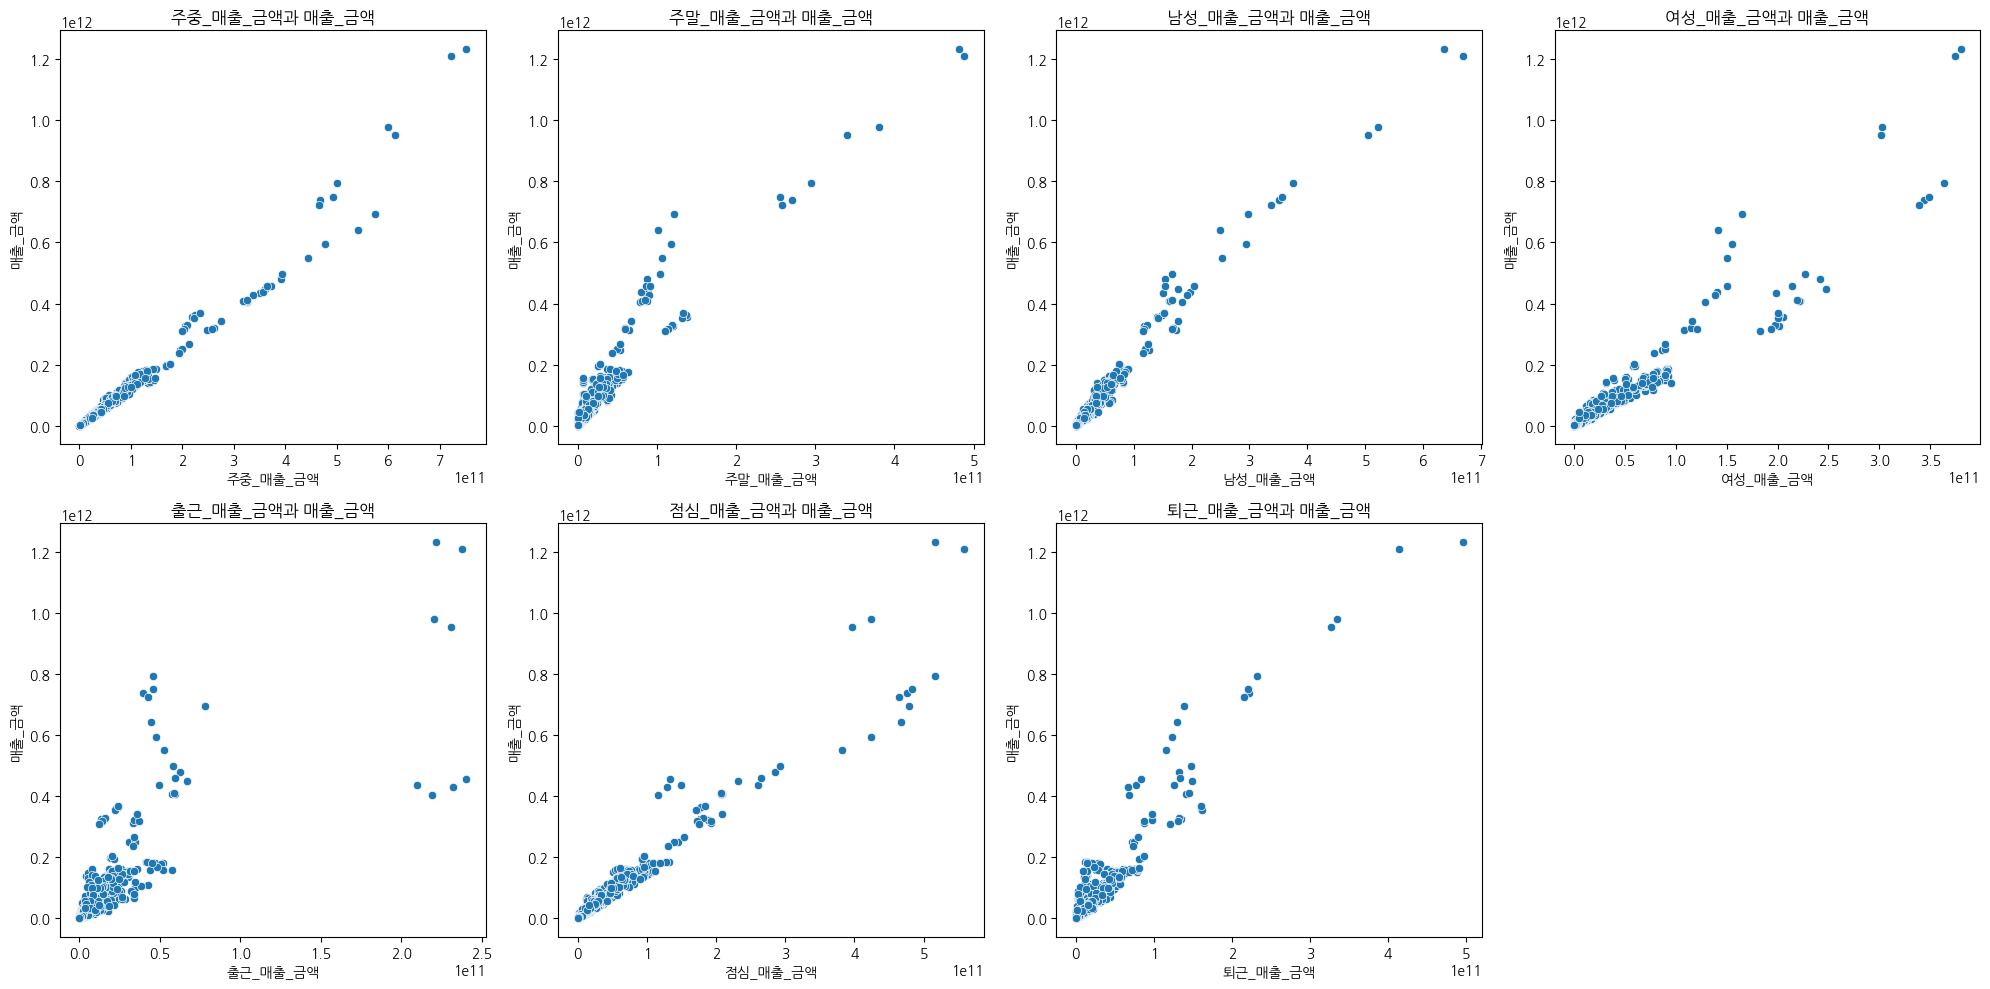

In [ ]:
list_sales = ["주중_매출_금액", "주말_매출_금액",
              "남성_매출_금액", "여성_매출_금액",
              "출근_매출_금액", "점심_매출_금액", "퇴근_매출_금액"]

n_cols = 4
n_rows = (len(list_sales) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for i, sale in enumerate(list_sales):
    sns.scatterplot(x=numeric_columns[sale], y=numeric_columns["매출_금액"], ax=axes[i])
    axes[i].set_title(f"{sale}과 매출_금액")
    axes[i].set_xlabel(sale)
    axes[i].set_ylabel("매출_금액")
    
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.show()

#### 직장 인구수와 매출 금액 관계

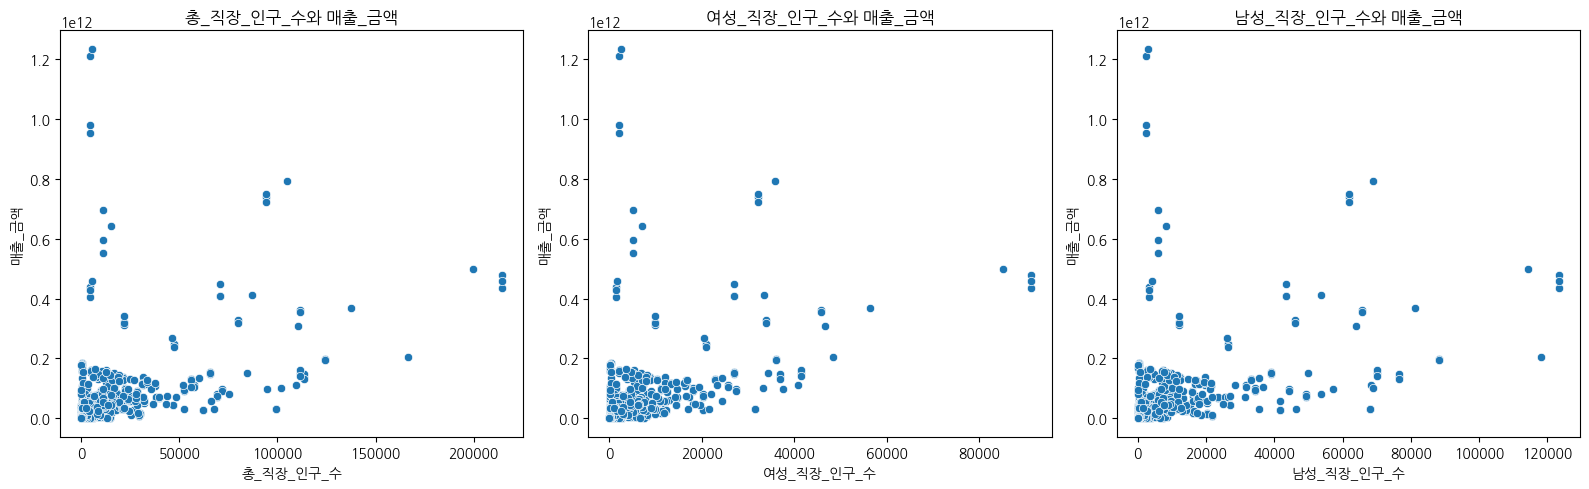

In [129]:
list_population = ["총_직장_인구_수", "여성_직장_인구_수", "남성_직장_인구_수"]

n_cols = 3
n_rows = (len(list_population) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten()

for i, population in enumerate(list_population):
    sns.scatterplot(x=numeric_columns[population], y=numeric_columns["매출_금액"], ax=axes[i])
    axes[i].set_title(f"{population}와 매출_금액")
    axes[i].set_xlabel(population)
    axes[i].set_ylabel("매출_금액")
    
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

#### 유동 인구수와 매출 금액 관계

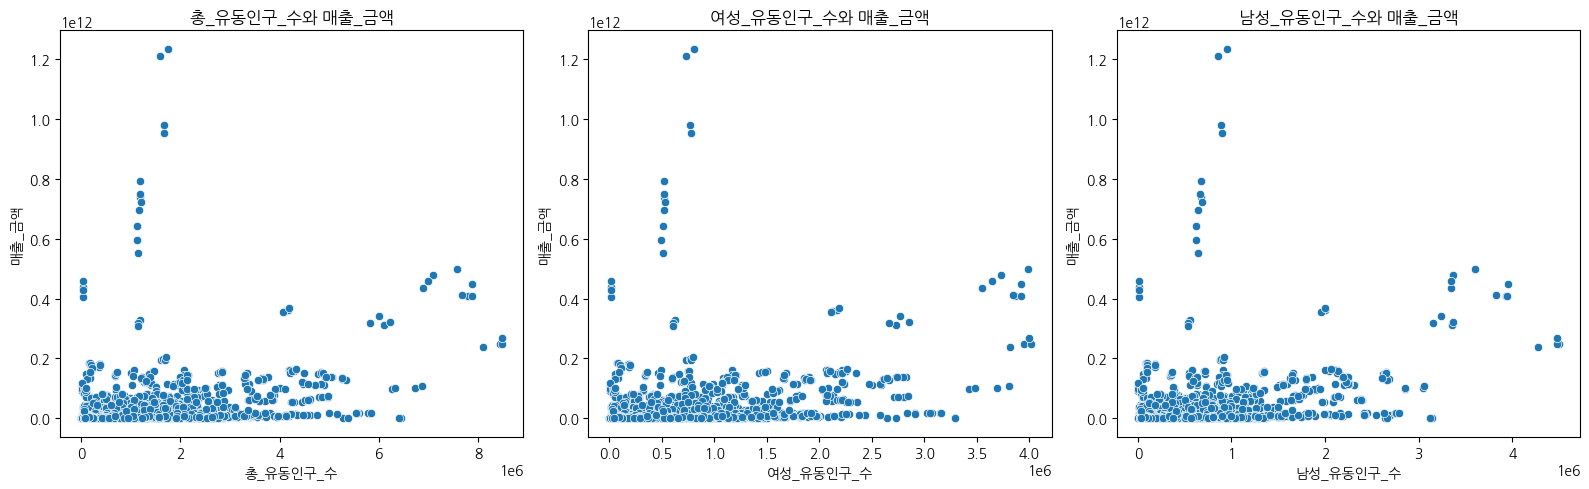

In [131]:
list_population = ["총_유동인구_수", "여성_유동인구_수", "남성_유동인구_수"]

n_cols = 3
n_rows = (len(list_population) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten()

for i, population in enumerate(list_population):
    sns.scatterplot(x=numeric_columns[population], y=numeric_columns["매출_금액"], ax=axes[i])
    axes[i].set_title(f"{population}와 매출_금액")
    axes[i].set_xlabel(population)
    axes[i].set_ylabel("매출_금액")
    
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

#### 상권구분별 매출 금액
> 어떤 상권에서의 매출 금액이 가장 높을지  
> 어떤 상권에서 소비가 많이 일어나는지(분포)  

발달상권에서의 판매가 많이 일어나지만, 관광특구에서의 매출 금액이 더 큼

In [116]:
seoul_data["상권_구분_코드_명"].unique()

array(['골목상권', '전통시장', '발달상권', '관광특구'], dtype=object)

In [117]:
count_by_region = seoul_data.groupby('상권_구분_코드_명').size()
count_by_region

상권_구분_코드_명
골목상권    4127
관광특구      24
발달상권     992
전통시장    1098
dtype: int64

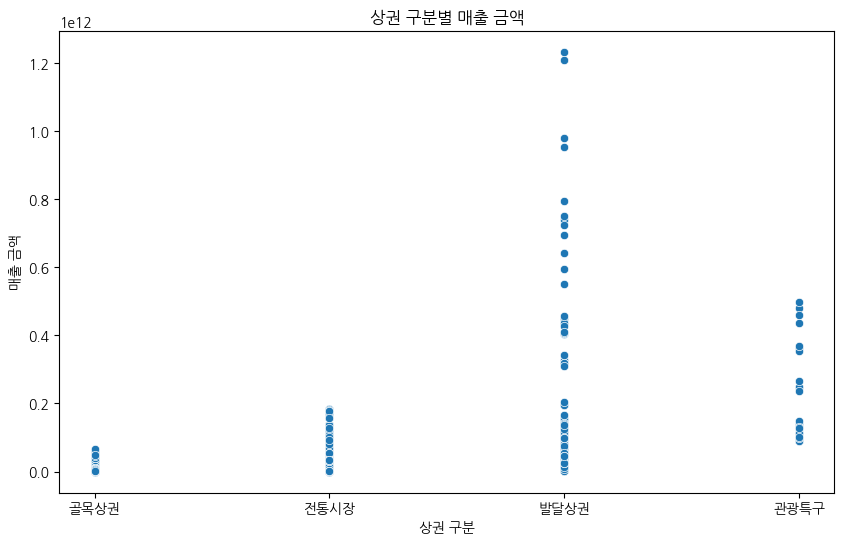

In [118]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=seoul_data, x="상권_구분_코드_명", y="매출_금액")
plt.title("상권 구분별 매출 금액")
plt.xlabel("상권 구분")
plt.ylabel("매출 금액")
plt.show()

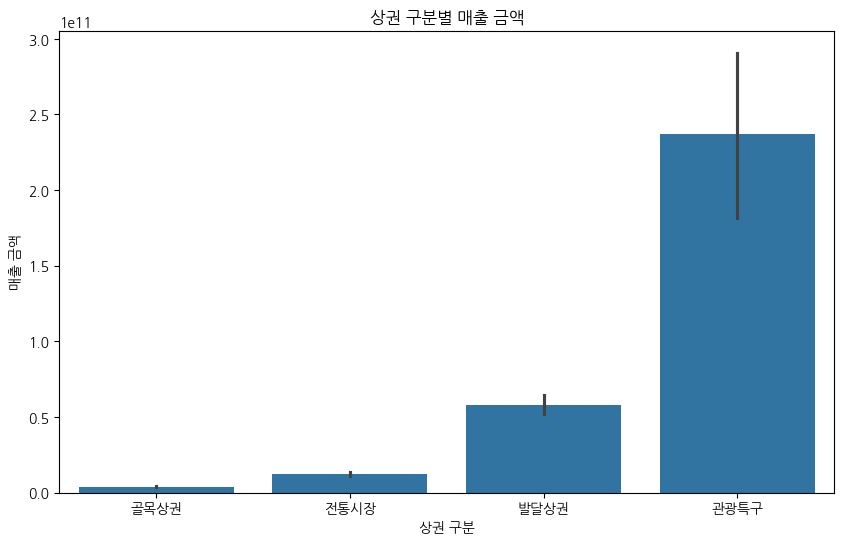

In [119]:
plt.figure(figsize=(10, 6))
sns.barplot(data=seoul_data, x="상권_구분_코드_명", y="매출_금액")
plt.title("상권 구분별 매출 금액")
plt.xlabel("상권 구분")
plt.ylabel("매출 금액")
plt.show()

barplot을보니 관광특구가 너무 높게 나왔다.  
이 이유는 다음과 같다.  

In [157]:
business_district=seoul_data[seoul_data["상권_구분_코드_명"]=="발달상권"]
business_district["매출_금액"].describe()

count    9.920000e+02
mean     5.783640e+10
std      1.041967e+11
min      9.535841e+07
25%      1.669164e+10
50%      3.317626e+10
75%      6.083545e+10
max      1.233510e+12
Name: 매출_금액, dtype: float64

In [158]:
tourist_region=seoul_data[seoul_data["상권_구분_코드_명"]=="관광특구"]
tourist_region["매출_금액"].describe()

count    2.400000e+01
mean     2.369201e+11
std      1.418105e+11
min      8.880033e+10
25%      1.143287e+11
50%      1.932370e+11
75%      3.586642e+11
max      4.971320e+11
Name: 매출_금액, dtype: float64

먼저 발달상권의 표준편차를 보면 매출의 변동이 상당히 크다.  
그리고 중앙값이 평균보다 낮은 것을 보니 매출이 고르게 분포하지 않고 일부 상권에서 높은 매출이 기록됐음을 알 수 있다.  

관광특구의 경우는 표준편차를 보니 발달상권보다 표준편차가 상대적으로 큰데,  
데이터의 개수가 적기 때문에 변동성이 상대적으로 커보인다.  

즉 발달상권은 매출 차이가 매우 커서 평균 매출이 높아지고, 중앙값은 그보다 낮아서 극단적으로 높은 값들이 평균에 영향을 미쳤다.  
관광특구의 경우는 매출이 상대적으로 고르게 분포하며, 평균이 발달상권보다 높다.  
또한 매출의 차이가 고르게있다.  

이에 따라서 평균으로 나오는 barplot에서 관광특구가 훨씬 높게 나온 것이다.  

#### 결측치 확인

In [40]:
seoul_data.isna().sum()

기준_년분기_코드     0
계절            0
상권_구분_코드_명    0
상권_코드_명       0
매출_금액         0
주중_매출_금액      0
주말_매출_금액      0
남성_매출_금액      0
여성_매출_금액      0
출근_매출_금액      0
점심_매출_금액      0
퇴근_매출_금액      0
총_유동인구_수      0
남성_유동인구_수     0
여성_유동인구_수     0
출근_유동인구_수     0
점심_유동인구_수     0
퇴근_유동인구_수     0
주중_유동인구_수     0
주말_유동인구_수     0
총_직장_인구_수     0
남성_직장_인구_수    0
여성_직장_인구_수    0
dtype: int64

#### 이상치 확인 - 기술통계량

In [41]:
seoul_data.describe().T

,count,mean,std,min,25%,50%,75%,max
기준_년분기_코드,6241.0,2.024250e+04,1.118482e+00,20241.0,2.024200e+04,2.024200e+04,2.024400e+04,2.024400e+04
매출_금액,6241.0,1.480777e+10,4.976934e+10,142495.0,1.034172e+09,3.440955e+09,1.052900e+10,1.233510e+12
주중_매출_금액,6241.0,1.123297e+10,3.545229e+10,0.0,7.741204e+08,2.552573e+09,8.094849e+09,7.515342e+11
주말_매출_금액,6241.0,3.574805e+09,1.544563e+10,0.0,2.400343e+08,7.978659e+08,2.480925e+09,4.882409e+11
남성_매출_금액,6241.0,6.758486e+09,2.337038e+10,0.0,5.092072e+08,1.694664e+09,5.050019e+09,6.679159e+11
여성_매출_금액,6241.0,6.386902e+09,2.026038e+10,0.0,3.809651e+08,1.363956e+09,4.558000e+09,3.798562e+11
출근_매출_금액,6241.0,2.241352e+09,9.543827e+09,0.0,9.522682e+07,4.170523e+08,1.495365e+09,2.402396e+11
점심_매출_금액,6241.0,7.463636e+09,2.676886e+10,0.0,4.299509e+08,1.524102e+09,5.001165e+09,5.589372e+11
퇴근_매출_금액,6241.0,5.102783e+09,1.642116e+10,0.0,4.298184e+08,1.340645e+09,3.892536e+09,4.954139e+11
총_유동인구_수,6241.0,8.568396e+05,9.009876e+05,4.0,2.564850e+05,5.913340e+05,1.188564e+06,8.484242e+06


상권별로 매출이 다를 수밖에 없기 때문에 이상치를 두고 진행한다.  

## CDA

상권별로 매출 금액의 차이가 있는가?
계절별로 매출 금액의 차이가 있는가?


In [ ]:
sns.histplot(data=tips, x="total_bill", kde=True)

<Axes: xlabel='매출_금액', ylabel='Count'>

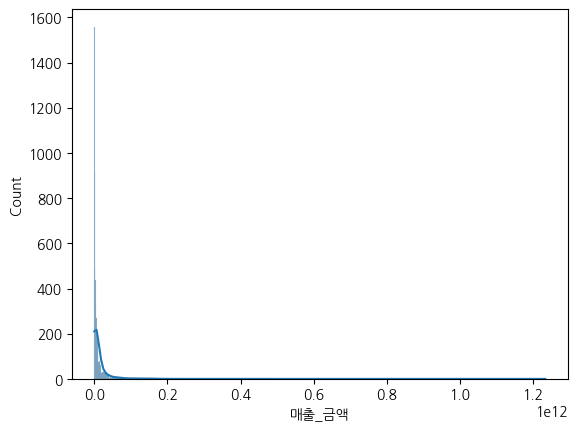

In [160]:
sns.histplot(data=seoul_data, x="매출_금액", kde=True)

In [162]:
stats.normaltest(seoul_data["매출_금액"])

NormaltestResult(statistic=np.float64(10869.043167986947), pvalue=np.float64(0.0))

In [163]:
seoul_data["상권_구분_코드_명"].value_counts()

상권_구분_코드_명
골목상권    4127
전통시장    1098
발달상권     992
관광특구      24
Name: count, dtype: int64

In [164]:
golmok=seoul_data[seoul_data["상권_구분_코드_명"]=="골목상권"]
jeontong=seoul_data[seoul_data["상권_구분_코드_명"]=="전통시장"]
baldal=seoul_data[seoul_data["상권_구분_코드_명"]=="발달상권"]
gwangwang=seoul_data[seoul_data["상권_구분_코드_명"]=="관광특구"]

In [165]:
stats.kruskal(golmok["매출_금액"],jeontong["매출_금액"],baldal["매출_금액"],gwangwang["매출_금액"])

KruskalResult(statistic=np.float64(2103.427612278357), pvalue=np.float64(0.0))

In [ ]:
stats.levene(tips_m["tip"], tips_f["tip"])